# Data Cleaning Notebook: Titanic Dataset

**Author:** Kristoffer Neo Senyahan  
**Email:** kristofferneo.senyahan@g.msuiit.edu.ph  
**GitHub:** https://github.com/magneofico  

---

## Overview

This notebook demonstrates a comprehensive data cleaning pipeline applied to the Titanic dataset from Kaggle. The Titanic dataset contains information about 891 passengers aboard the RMS Titanic, including demographic data (age, sex, passenger class), ticket information (fare, cabin), and survival outcome.

## Objectives

The goal of this project is to:
1. **Identify and document data quality issues** (missing values, duplicates, outliers)
2. **Apply systematic cleaning techniques** (standardization, imputation, outlier treatment)
3. **Preserve data integrity** through informed decision-making at each step
4. **Quantify improvements** using before/after comparisons and correlation analysis

## Dataset

- **Source:** Kaggle's Titanic: Machine Learning from Disaster
- **File:** `../data/raw_dataset.csv`
- **Size:** 891 passengers, 12 original features
- **Missing Data:** Age (~19%), Cabin (~77%), Embarked (~0.2%)
- **Key Columns:** PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

## Process Summary

### Phase 1: Exploration
- Load raw data and inspect structure
- Visualize distributions of key numeric and categorical features
- Identify missing values and duplicates

### Phase 2: Cleaning
1. **Standardize string formats** → lowercase, strip whitespace
2. **Handle missing values** → mode for Embarked, median-by-group for Age, median for Fare
3. **Feature engineering** → extract Deck letter from Cabin, create HasCabin indicator
4. **Optimize data types** → convert low-cardinality columns to categorical (memory savings)
5. **Remove duplicates** → drop exact row duplicates
6. **Detect outliers** → IQR-based winsorization for Age and Fare

### Phase 3: Validation
- Compare before/after statistics (shapes, distributions, summary stats)
- Visualize missing value reduction via heatmaps
- Analyze correlation changes to quantify cleaning impact

## Deliverables

This notebook captures:
- ✅ Shapes before/after cleaning
- ✅ Sample rows before/after
- ✅ Summary statistics before/after
- ✅ Detailed rationale for each cleaning step
- ✅ Correlation analysis showing data quality improvement
- ✅ Visual comparisons (histograms, heatmaps)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")

## 1) Load raw dataset

In [30]:
RAW_PATH = '../data/raw_dataset.csv'
df = pd.read_csv(RAW_PATH)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2) Initial exploration

In [31]:
pd.DataFrame({
    'DataType': df.dtypes,
    'NonNullCount': df.notnull().sum(),
    'MissingCount': df.isna().sum(),
    'UniqueValues': df.nunique()
})


,DataType,NonNullCount,MissingCount,UniqueValues
PassengerId,int64,891,0,891
Survived,int64,891,0,2
Pclass,int64,891,0,3
Name,object,891,0,891
Sex,object,891,0,2
Age,float64,714,177,88
SibSp,int64,891,0,7
Parch,int64,891,0,7
Ticket,object,891,0,681
Fare,float64,891,0,248


In [32]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


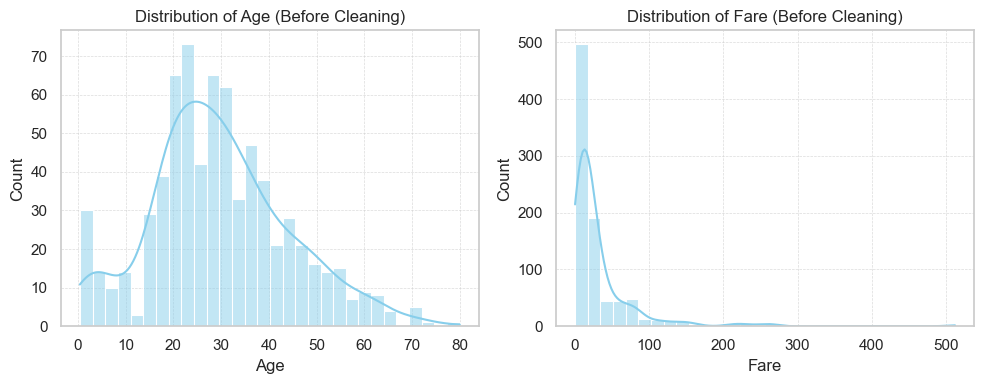

In [33]:
# Select numeric columns of interest
columns = ['Age', 'Fare']

plt.figure(figsize=(10,4))
for i, c in enumerate(columns):
    plt.subplot(1, 2, i+1)
    sns.histplot(df[c], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {c} (Before Cleaning)")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


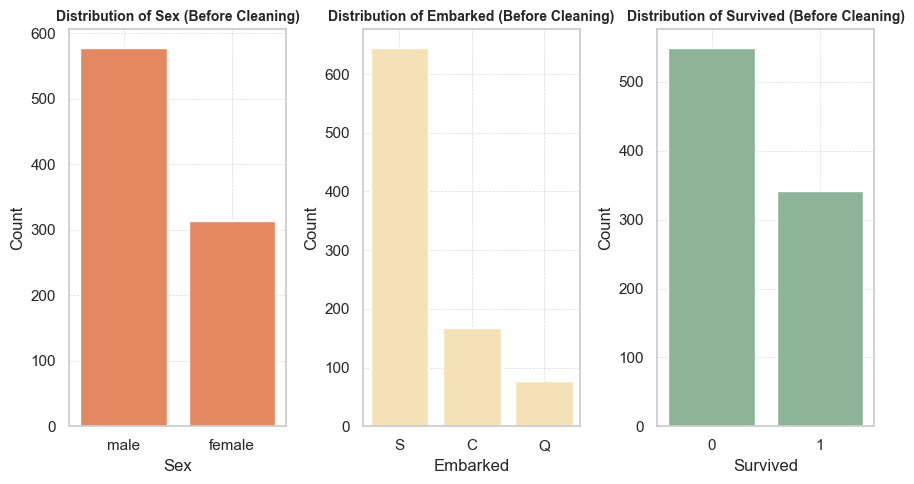

In [34]:
# Select numeric columns of interest
columns = ['Sex', 'Embarked', 'Survived']

# Use Seaborn's Spectral palette (as many colors as columns)
colors = sns.color_palette("Spectral", n_colors=len(columns))
colors = sns.color_palette([(r*1, g*0.9, b*0.9) for r, g, b in colors])


plt.figure(figsize=(9, 5))
for i, c in enumerate(columns):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=c, color=colors[i])  # use 'color' not 'palette'
    plt.title(f"Distribution of {c} (Before Cleaning)", fontsize=10, fontweight='bold')
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### Missing values & duplicates overview

In [35]:
mv = df.isna().sum().sort_values(ascending=False)
mv

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [36]:
dup_count = df.duplicated().sum()
dup_count

0

## 3) Cleaning

### 3.1 Standardize string formats


In [37]:
# Copy the raw data for transformation
clean = df.copy()

# Standardize text columns often present in Titanic
for col in ['Sex', 'Embarked']:
    if col in clean.columns:
        clean[col] = (clean[col]
                      .astype('string')
                      .str.strip()
                      .str.lower())
clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,s
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,c
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,s
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,s
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,s


### 3.2 Handle missing values

**Strategy:**
- **Embarked:** filled with mode (most frequent port)
- **Age:** imputed with median by Passenger Class & Sex (respects socioeconomic/gender patterns in ticket allocation)
- **Fare:** filled with median (preserves price distribution)
- **Deck:** extracted from Cabin; unknown values marked as 'U' to preserve cabin information

In [38]:
# Fill Embarked with mode
if 'Embarked' in clean.columns:
    mode_emb = clean['Embarked'].mode(dropna=True)
    if len(mode_emb):
        clean['Embarked'] = clean['Embarked'].fillna(mode_emb.iloc[0])

# Age imputation: median by Pclass and Sex (vectorized - more efficient)
if set(['Age','Pclass','Sex']).issubset(clean.columns):
    age_median_by_group = clean.groupby(['Pclass','Sex'])['Age'].transform('median')
    clean['Age'] = clean['Age'].fillna(age_median_by_group)
    # Fill any remaining NaN with overall median
    clean['Age'] = clean['Age'].fillna(clean['Age'].median())

# Cabin: extract Deck letter when present
if 'Cabin' in clean.columns:
    clean['Deck'] = clean['Cabin'].astype('string').str[0]
    # Optional: fill unknown decks with 'U'
    clean['Deck'] = clean['Deck'].fillna('U')

# Ticket normalization: strip spaces
if 'Ticket' in clean.columns:
    clean['Ticket'] = clean['Ticket'].astype('string').str.strip()

clean[['Age','Embarked']].head() if set(['Age','Embarked']).issubset(clean.columns) else clean.head()

,Age,Embarked
0,22.0,s
1,38.0,c
2,26.0,s
3,35.0,s
4,35.0,s


In [39]:
# Convert low-cardinality columns to category (saves memory & speeds groupby operations)
for c in ['Sex','Embarked','Pclass','Deck']:
    if c in clean.columns:
        clean[c] = clean[c].astype('category')

# Ensure Fare has no NaNs before winsorizing
if 'Fare' in clean.columns:
    clean['Fare'] = clean['Fare'].fillna(clean['Fare'].median())

print("Categorical columns applied. Memory usage before/after:")
print(f"  Raw (object): {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"  Clean (category): {clean.memory_usage(deep=True).sum() / 1024:.2f} KB")

Categorical columns applied. Memory usage before/after:
  Raw (object): 285.61 KB
  Clean (category): 193.25 KB


### 3.3 Remove duplicates

In [40]:
before = clean.shape[0]
clean = clean.drop_duplicates()
after = clean.shape[0]
print({'rows_before': before, 'rows_after': after, 'dropped': before-after})

{'rows_before': 891, 'rows_after': 891, 'dropped': 0}


### 3.4 Outlier detection/treatment (IQR) for numeric columns like Age/Fare

In [41]:
def winsorize_iqr(s: pd.Series, k: float = 1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return s.clip(lower, upper)

for col in ['Age','Fare']:
    if col in clean.columns:
        clean[col] = winsorize_iqr(clean[col].astype(float), k=1.5)

clean[['Age','Fare']].describe() if set(['Age','Fare']).issubset(clean.columns) else clean.describe()

,Age,Fare
count,891.000000,891.000000
mean,28.893850,24.046813
std,12.732352,20.481625
min,0.420000,0.000000
25%,21.500000,7.910400
50%,26.000000,14.454200
75%,36.000000,31.000000
max,57.750000,65.634400


## 4) Before/After snapshots

In [42]:
print('Raw shape:', df.shape)
print('Clean shape:', clean.shape)

display(df.describe(include='all').T)
display(clean.describe(include='all').T)

Raw shape: (891, 12)
Clean shape: (891, 13)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,3.0,3.0,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,891.0,NaN,NaN,NaN,28.89385,12.732352,0.42,21.5,26.0,36.0,57.75
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,24.046813,20.481625,0.0,7.9104,14.4542,31.0,65.6344


In [43]:
# Create HasCabin indicator BEFORE creating visualizations (for consistency)
df['HasCabin'] = df['Cabin'].notnull().astype(int)
clean['HasCabin'] = clean['Cabin'].notnull().astype(int)

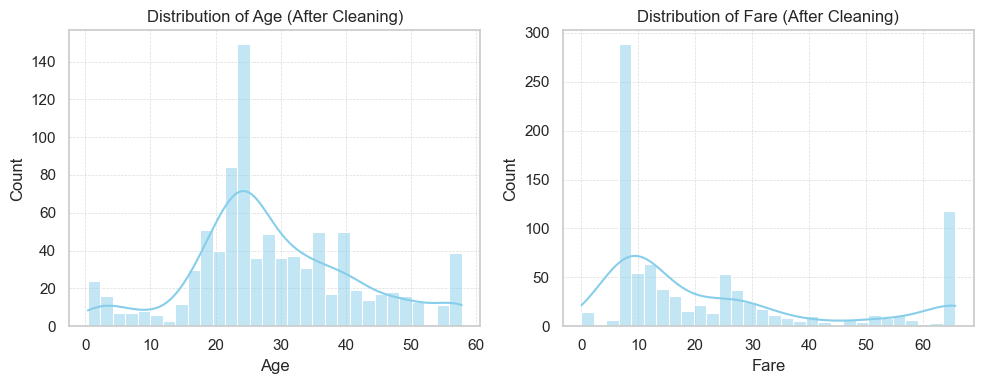

In [44]:
# Select numeric columns of interest
columns = ['Age', 'Fare']

plt.figure(figsize=(10,4))
for i, c in enumerate(columns):
    plt.subplot(1, 2, i+1)
    sns.histplot(clean[c], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {c} (After Cleaning)")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
plt.tight_layout()
plt.show()

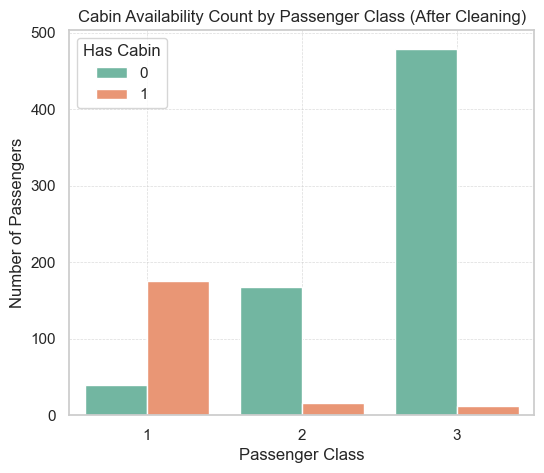

In [45]:
plt.figure(figsize=(6,5))
sns.countplot(
    data=clean,
    x='Pclass',
    hue='HasCabin',
    palette='Set2'
)
plt.title('Cabin Availability Count by Passenger Class (After Cleaning)')
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')
plt.legend(title='Has Cabin')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [46]:
mv = clean.isna().sum().sort_values(ascending=False); mv

Cabin          687
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Deck             0
HasCabin         0
dtype: int64

This codeblock visualized through a heatmap the missing values of each column before(raw data) and after(data cleaned) in the database.

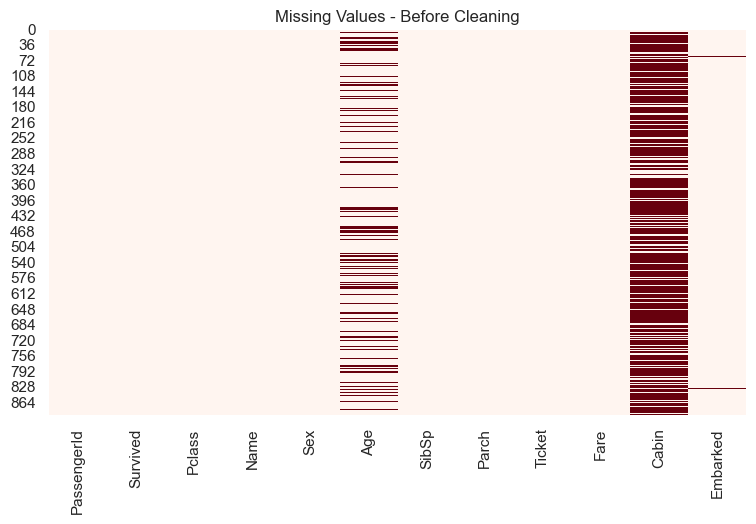

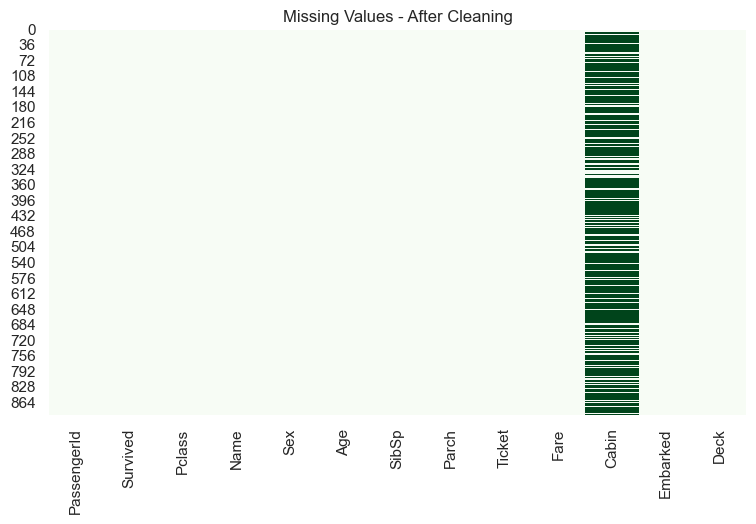

In [47]:
plt.figure(figsize=(9,5))
sns.heatmap(df.drop(columns=['HasCabin']).isna(), cbar=False, cmap="Reds")
plt.title("Missing Values - Before Cleaning")
plt.show()

plt.figure(figsize=(9,5))
sns.heatmap(clean.drop(columns=['HasCabin']).isna(), cbar=False, cmap="Greens")
plt.title("Missing Values - After Cleaning")
plt.show()

### Correlation Analysis: Quantify impact of cleaning

Shows which features have the strongest relationships before and after imputation/outlier handling.

In [48]:
print("CORRELATION - Raw Data:")
corr_raw = df.select_dtypes(include=[np.number]).corr()
display(corr_raw)

print("\nCORRELATION - Cleaned Data:")
corr_clean = clean.select_dtypes(include=[np.number]).corr()
display(corr_clean)

print("\nDifference (impact of cleaning):")
diff = (corr_clean - corr_raw).abs()
display(diff.where(diff > 0.01, 0).round(3))  # Show only meaningful changes

CORRELATION - Raw Data:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.019919
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.316912
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.725541
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.249732
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.040460
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.036987
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.482075
HasCabin,0.019919,0.316912,-0.725541,0.249732,-0.040460,0.036987,0.482075,1.000000



CORRELATION - Cleaned Data:


,PassengerId,Survived,Age,SibSp,Parch,Fare,HasCabin
PassengerId,1.000000,-0.005007,0.039751,-0.057527,-0.001652,0.003243,0.019919
Survived,-0.005007,1.000000,-0.057132,-0.035322,0.081629,0.317430,0.316912
Age,0.039751,-0.057132,1.000000,-0.255370,-0.180723,0.181736,0.278992
SibSp,-0.057527,-0.035322,-0.255370,1.000000,0.414838,0.332021,-0.040460
Parch,-0.001652,0.081629,-0.180723,0.414838,1.000000,0.292616,0.036987
Fare,0.003243,0.317430,0.181736,0.332021,0.292616,1.000000,0.617669
HasCabin,0.019919,0.316912,0.278992,-0.040460,0.036987,0.617669,1.000000



Difference (impact of cleaning):


,Age,Fare,HasCabin,Parch,PassengerId,Pclass,SibSp,Survived
Age,0.000,0.086,0.029,0.000,0.0,0.0,0.053,0.02
Fare,0.086,0.000,0.136,0.076,0.0,0.0,0.172,0.06
HasCabin,0.029,0.136,0.000,0.000,0.0,0.0,0.000,0.00
Parch,0.000,0.076,0.000,0.000,0.0,0.0,0.000,0.00
PassengerId,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.00
Pclass,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.00
SibSp,0.053,0.172,0.000,0.000,0.0,0.0,0.000,0.00
Survived,0.020,0.060,0.000,0.000,0.0,0.0,0.000,0.00


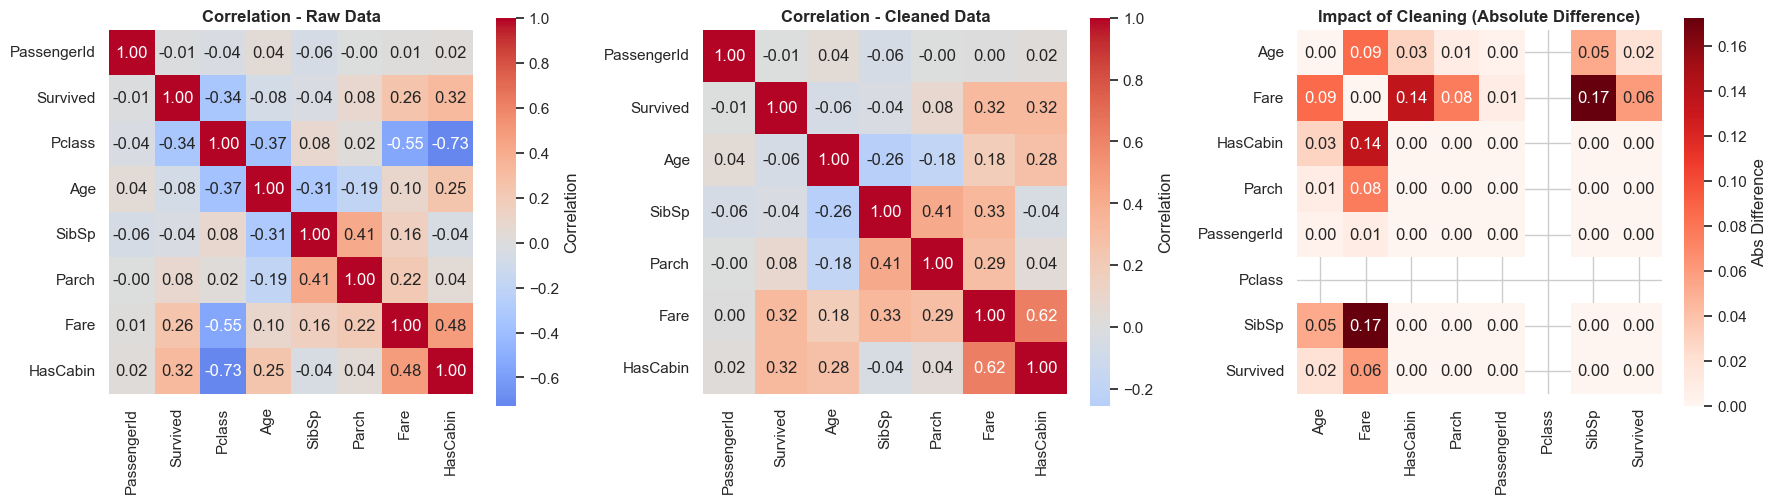

In [49]:

# Visualize correlation difference as heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Raw data correlations
sns.heatmap(corr_raw, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Correlation - Raw Data', fontsize=12, fontweight='bold')

# Cleaned data correlations
sns.heatmap(corr_clean, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Correlation - Cleaned Data', fontsize=12, fontweight='bold')

# Difference (impact of cleaning)
sns.heatmap(diff, annot=True, fmt='.2f', cmap='Reds', 
            square=True, ax=axes[2], cbar_kws={'label': 'Abs Difference'})
axes[2].set_title('Impact of Cleaning (Absolute Difference)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 5) Save cleaned dataset

### 3.5 Cabin & Feature Summary

**Decision:** Keep `Deck` + `HasCabin` (extracted features); drop original `Cabin` column (sparse, text-heavy, less predictive than engineered features).
- **Deck:** passenger's cabin deck letter (proxy for ship location/amenities; 'U' = unknown)
- **HasCabin:** binary indicator (1 = cabin recorded, 0 = missing); correlates with ticket price & passenger class

In [50]:
CLEAN_PATH = '../data/cleaned_dataset.csv'

# Drop original sparse Cabin column (we've extracted Deck + HasCabin)
clean_export = clean.drop(columns=['Cabin'], errors='ignore')

clean_export.to_csv(CLEAN_PATH, index=False)
print('Saved:', CLEAN_PATH)
print(f'Columns: {list(clean_export.columns)}')

Saved: ../data/cleaned_dataset.csv
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Deck', 'HasCabin']
